In [200]:
import numpy as np
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
from PIL import Image

## Aiden, Andrew, Cathy

## 전체 사진 중 최대 해상도 찾기

In [201]:
dirNames = ['Aiden','Andrew','Cathy']

widthRatio = []
heightRatio = []
for name in dirNames:
    for file in sorted(glob.glob("./Data/Face/%s/*.jpg"%name)):
        img = np.array(Image.open(file), dtype=np.int32)
        widthRatio.append(img.shape[1])
        heightRatio.append(img.shape[0])

In [202]:
print("Width :",np.max(widthRatio))
print("Height :",np.max(heightRatio))

Width : 299
Height : 381


> 해상도 지정: 400x300

### 이미지를 400x300 고정 크기로 생성하고 중심에 맞추기

In [203]:
# 전체 파일명
for name in dirNames:
    fileCount = 0

    for file in sorted(glob.glob("./Data/Face/%s/*.jpg"%name)):
        img = Image.open(file)
        imgResize = img.convert('L')
        imgArray = np.array(imgResize)
        # 센터 정렬 전 배경 검정색인 더미데이터 준비
        imgDummy = np.zeros(400*300).reshape(400,300)
        rowNum = (400-imgArray.shape[0])/2
        colNum = (300-imgArray.shape[1])/2

        # empty list에 image array 붙이기 (4차원 배열 생성)
        k = 0
        for i in list(range(int(rowNum),int(rowNum)+imgArray.shape[0])):
            l = 0
            for j in list(range(int(colNum),int(colNum)+imgArray.shape[1])):
                imgDummy[i,j] = imgArray[k,l]
                l+=1
            k+=1
        
        img2 = Image.fromarray(imgDummy.astype('uint8'),'L')
        img2.save("./Data/FaceGray/%s/image_%04d.jpg"%(name,fileCount),'JPEG')
        fileCount+=1


### numpy 배열을 이용하여 training data 만들기

In [204]:
number_of_data = 18*len(dirNames)
img_width_size = 300
img_height_size = 400
train = np.zeros(number_of_data*img_height_size*img_width_size, dtype=np.int32).reshape(number_of_data,img_height_size,img_width_size)

i = 0
for name in dirNames:
    for file in sorted(glob.glob("./Data/FaceGray/%s/*.jpg"%name)):
    # for file in sorted(glob.glob("./Data/FaceColor/%s/*.jpg"%name)):
        img = np.array(Image.open(file),dtype=np.int32)
        train[i,:,:] = img
        i+=1
        if i >= 54:
            break


In [205]:
train.shape

(54, 400, 300)

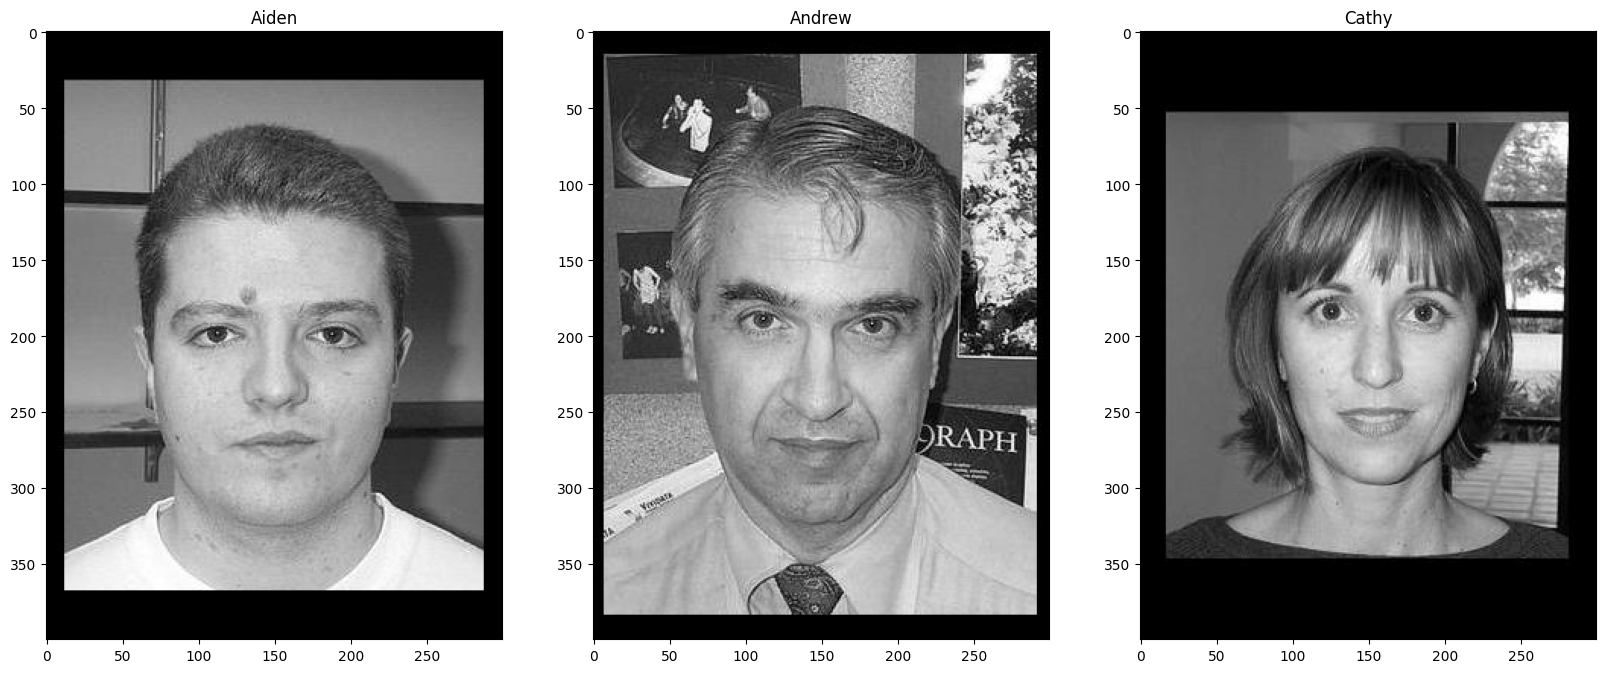

In [206]:
plt.figure(figsize=(20,20))
# Aiden, Andrew, Cathy 각 인물의 첫번째 사진 확인하기
orderNo = list(range(0,len(dirNames)*18,18))

for i in list(range(1,len(dirNames)+1)):
    plt.subplot(1,len(dirNames),i)
    plt.imshow(train[orderNo[i-1]].reshape(400,300),cmap='gray')
    plt.title(dirNames[i-1])



### target data

In [207]:
# target 생성
target = np.concatenate([np.zeros(18),np.ones(18),np.full(18,2)])

### split

In [208]:
# data split
from sklearn.model_selection import train_test_split
train_scaled = train.reshape(-1, 400, 300, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, target, test_size=0.2, random_state=42)

### CNN

In [209]:
# model
model = keras.Sequential()
# 합성곱 층
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding='same', input_shape = (400,300,1)))
# 풀링 층
model.add(keras.layers.MaxPooling2D(2))
# model.add(keras.layers.AveragePooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
# model.add(keras.layers.AveragePooling2D(2))
# Dense 층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
# model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3,activation='softmax'))

In [210]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_cnn_face.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# history = model.fit(train_scaled, train_target, epochs=20, validation_data=[val_scaled,val_target],callbacks=[checkpoint_cb,early_stopping_cb])
history = model.fit(train_scaled, train_target, epochs=20, validation_data=[val_scaled,val_target],callbacks=[checkpoint_cb])

Epoch 1/20
2/2 [==============================] - 3s 834ms/step - loss: 6.8639 - accuracy: 0.3953 - val_loss: 2.4234 - val_accuracy: 0.5455
Epoch 2/20
2/2 [==============================] - 2s 708ms/step - loss: 2.5499 - accuracy: 0.4651 - val_loss: 0.8816 - val_accuracy: 0.5455
Epoch 3/20
2/2 [==============================] - 2s 754ms/step - loss: 1.5715 - accuracy: 0.6512 - val_loss: 2.5457 - val_accuracy: 0.5455
Epoch 4/20
2/2 [==============================] - 2s 784ms/step - loss: 0.5108 - accuracy: 0.8605 - val_loss: 1.3836 - val_accuracy: 0.8182
Epoch 5/20
2/2 [==============================] - 2s 693ms/step - loss: 0.1373 - accuracy: 0.9535 - val_loss: 0.9724 - val_accuracy: 0.7273
Epoch 6/20
2/2 [==============================] - 2s 914ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.7511 - val_accuracy: 0.7273
Epoch 7/20
2/2 [==============================] - 2s 724ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.7960 - val_accuracy: 0.8182
Epoch 8/20
2/2 [====

In [211]:
best_model = keras.models.load_model("./Data/best_cnn_face.h5")
best_model.evaluate(train_scaled,train_target)

2/2 [==============================] - 1s 84ms/step - loss: 1.1172e-05 - accuracy: 1.0000


[1.117202737077605e-05, 1.0]

In [212]:
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 400, 300, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 200, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 200, 150, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 100, 75, 64)      0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 480000)            0         
                                                                 
 dense_22 (Dense)            (None, 100)             

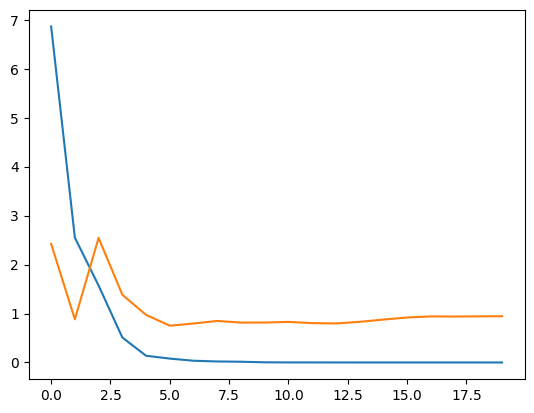

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

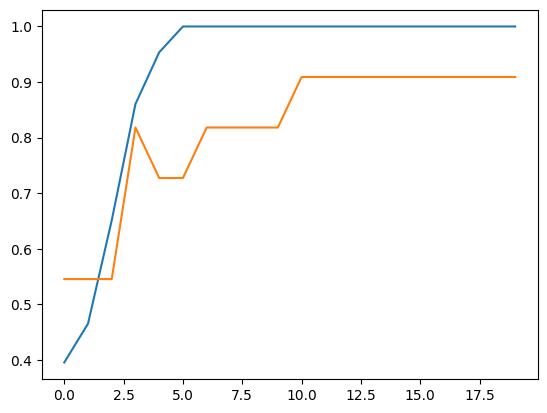

In [214]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

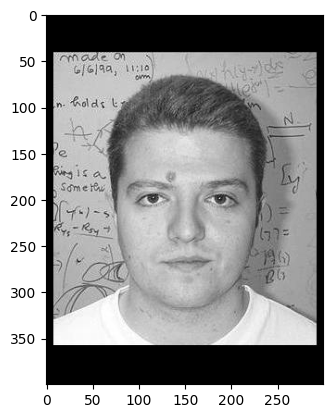

1/1 [==============================] - 0s 62ms/step
Aiden


In [215]:
names = ['Aiden','Andrew','Cathy']
plt.imshow(val_scaled[10].reshape(400,300),cmap='gray')
plt.show()
preds = best_model.predict(val_scaled[10:11])
print(names[np.argmax(preds)])

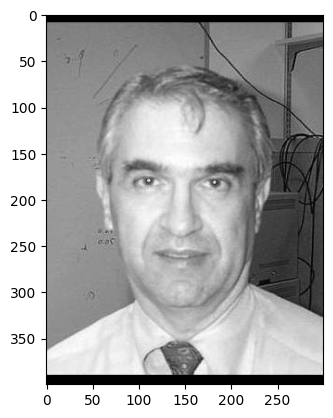

1/1 [==============================] - 0s 25ms/step
Andrew


In [216]:
names = ['Aiden','Andrew','Cathy']
plt.imshow(val_scaled[0].reshape(400,300),cmap='gray')
plt.show()
preds = best_model.predict(val_scaled[0:1])
print(names[np.argmax(preds)])

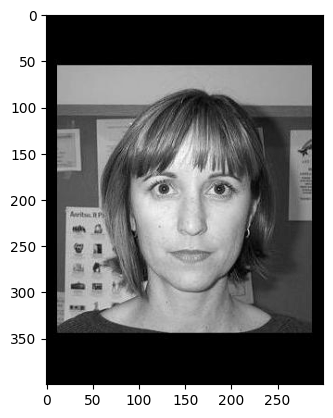

1/1 [==============================] - 0s 26ms/step
Cathy


In [217]:
names = ['Aiden','Andrew','Cathy']
plt.imshow(val_scaled[2].reshape(400,300),cmap='gray')
plt.show()
preds = best_model.predict(val_scaled[2:3])
print(names[np.argmax(preds)])